> pip install keybert

https://maartengr.github.io/KeyBERT/index.html

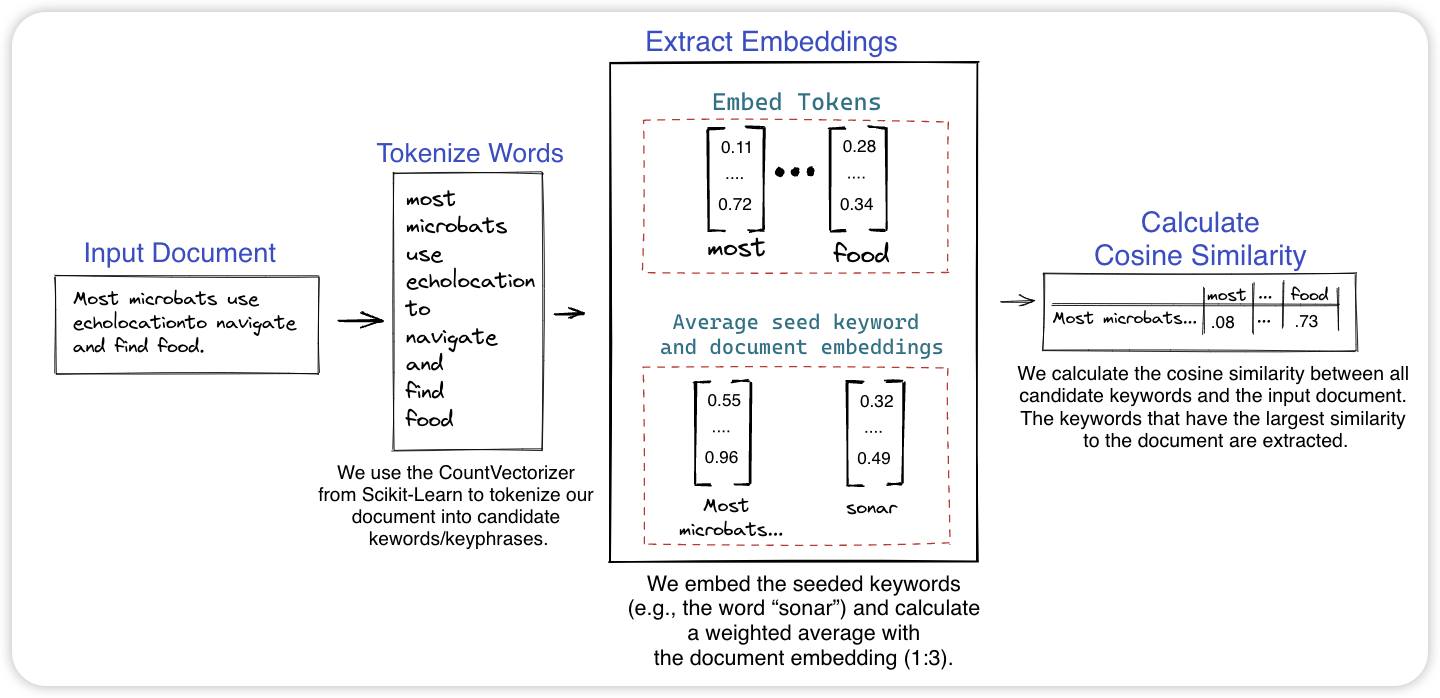

In [1]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

from keybert import KeyBERT

doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs.[1] It infers a
         function from labeled training data consisting of a set of training examples.[2]
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal).
         A supervised learning algorithm analyzes the training data and produces an inferred function,
         which can be used for mapping new examples. An optimal scenario will allow for the
         algorithm to correctly determine the class labels for unseen instances. This requires
         the learning algorithm to generalize from the training data to unseen situations in a
         'reasonable' way (see inductive bias).
      """
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc)

/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 1), stop_words=None)

[('supervised', 0.6523),
 ('labeled', 0.4702),
 ('learning', 0.467),
 ('training', 0.3858),
 ('labels', 0.3728)]

In [3]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None)

[('supervised learning', 0.6658),
 ('supervised', 0.6523),
 ('signal supervised', 0.6074),
 ('in supervised', 0.5941),
 ('labeled training', 0.5779)]

## Max Sum Distance

Max Sum Distance 方法首先选取与文档最相似的一定数量的词或短语作为候选，然后从这些候选中找出相互之间最不相似的组合作为关键词。这种方法通过最大化候选关键词之间的距离来增加结果的多样性

```python
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple


def max_sum_distance(
    doc_embedding: np.ndarray,
    word_embeddings: np.ndarray,
    words: List[str],
    top_n: int,
    nr_candidates: int,
) -> List[Tuple[str, float]]:
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, word_embeddings)
    distances_words = cosine_similarity(word_embeddings, word_embeddings)

    # Get 2*top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [words[index] for index in words_idx]
    candidates = distances_words[np.ix_(words_idx, words_idx)]

    # Calculate the combination of words that are the least similar to each other
    min_sim = 100_000
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [(words_vals[idx], round(float(distances[0][words_idx[idx]]), 4)) for idx in candidate]
```

In [4]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), stop_words='english', use_maxsum=True, nr_candidates=20, top_n=5)

[('training data unseen', 0.5025),
 ('learning algorithm analyzes', 0.5127),
 ('learning function maps', 0.5211),
 ('machine learning task', 0.5496),
 ('supervisory signal supervised', 0.5705)]

## Maximal Marginal Relevance (MMR)
另一种多样化关键词的方法，它在选取关键词时不仅考虑与文档的相似度，还考虑已选取关键词之间的差异性。通过引入一个参数来平衡关键词的相关性和多样性，从而生成具有高度多样性的关键词列表。

```python
def mmr(
    doc_embedding: np.ndarray,
    word_embeddings: np.ndarray,
    words: List[str],
    top_n: int = 5,
    diversity: float = 0.8,
) -> List[Tuple[str, float]]:
    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(min(top_n - 1, len(words) - 1)):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1 - diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    # Extract and sort keywords in descending similarity
    keywords = [(words[idx], round(float(word_doc_similarity.reshape(1, -1)[0][idx]), 4)) for idx in keywords_idx]
    keywords = sorted(keywords, key=itemgetter(1), reverse=True)
    return keywords
```

In [5]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), stop_words='english', use_mmr=True, diversity=0.7)

[('supervised learning algorithm', 0.6834),
 ('class labels unseen', 0.3239),
 ('value called supervisory', 0.2705),
 ('unseen situations reasonable', 0.2158),
 ('pairs infers function', 0.1953)]

## 中文兼容

In [15]:
import hanlp
tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)
pos = hanlp.load(hanlp.pretrained.pos.CTB9_POS_ELECTRA_SMALL)

In [26]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
import jieba

doc = """
林黛玉，中国古典名著《红楼梦》中的人物，金陵十二钗正册之首，西方灵河岸绛珠仙草转世，荣府幺女贾敏与扬州巡盐御史林如海之独生女，母亲贾敏是贾代善和贾母四个女儿里最小的女儿，贾母的外孙女，贾宝玉的姑表妹、恋人、知己，贾府通称林姑娘。
"""

kw_model = KeyBERT(model='BAAI/bge-small-zh-v1.5')

In [43]:
vectorizer = CountVectorizer(tokenizer=tok)
# vectorizer = CountVectorizer(tokenizer=jieba.lcut)

kw_model.extract_keywords(doc, vectorizer=vectorizer, top_n=20)

/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[('林黛玉', 0.7347),
 ('红楼梦', 0.5901),
 ('贾宝玉', 0.5865),
 ('贾母', 0.5861),
 ('贾敏', 0.5541),
 ('钗', 0.5137),
 ('母亲', 0.5016),
 ('贾府', 0.4961),
 ('贾代善', 0.4881),
 ('姑娘', 0.4861),
 ('姑', 0.475),
 ('林', 0.4714),
 ('女', 0.4651),
 ('女儿', 0.4576),
 ('绛', 0.4549),
 ('外孙女', 0.428),
 ('林如海', 0.4211),
 ('独生女', 0.4205),
 ('人物', 0.3914),
 ('名著', 0.3707)]

In [41]:
vectorizer = CountVectorizer(tokenizer=tok, ngram_range=(2,2))
# vectorizer = CountVectorizer(tokenizer=jieba.lcut)

kw_model.extract_keywords(doc, vectorizer=vectorizer)

/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[('林黛玉 ，', 0.7458),
 ('贾敏 是', 0.6246),
 ('母亲 贾敏', 0.623),
 ('贾宝玉 的', 0.6176),
 ('《 红楼梦', 0.6128)]